In [4]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)

In [5]:
# Preparing the Classification variables
Y_class = hs_2017['sat_high_level']
X_class = hs_2017.drop(columns=['nc_district', 'sat_high_level', 'sat_avg_score_num'])

from sklearn.preprocessing import StandardScaler

# Standardize the data to a more normally distributed data
scaler_class = StandardScaler()
scaler_class.fit(X_class)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
#Divide data into test and training splits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score, f1_score


# Generate a 60/40 training/test split of data
X_train, X_test, y_train, y_test = train_test_split(X_class, Y_class, test_size=0.1, random_state=0)

# Generate & train instance of RandomForest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# EvaluateClassifierEstimator(rf, X_class, Y_class, cv_class)

C:\ProgramData\Anaconda3\envs\MSDS7331\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

First we run the KMeans with the default 8 clusters.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# X1 = df_imputed[['Pclass','Fare']]
clf = rf

cls = KMeans(n_clusters=8, init='k-means++',n_init=10,random_state=1)
cls.fit(X_class)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = df_imputed['Survived']
# X = df_imputed[['Age','IsMale','Parch','SibSp']]
X = np.column_stack((X_class,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)

print ("Average accuracy (with kmeans)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans)=  86.51162790697674 +- 4.855956515772347


By utilizing the 'Elbow method', we attempt to identify the optimal number of clusters as identified by the inflection point, or 'elbow', achieved at the point where the SSE reaches an observably low point.  
What we see instead is a smooth curve which indicates that the data may not be very clustered.  
(See Robert Gove's Block: https://bl.ocks.org/rpgove/0060ff3b656618e9136b)

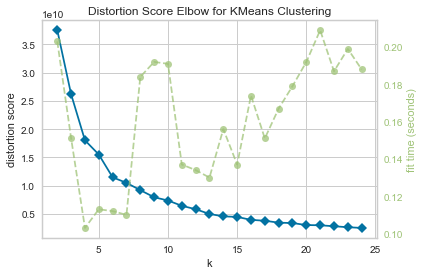

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,25))

visualizer.fit(X_class) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

We'll look instead at silhouette scores.

We'll run a for each loop to compute the silhouette coefficient - as well as the mean accuracy and standard deviation - for KMeans with 2-200 clusters.  
We'll output the results to a dataframe for analysis.

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import pairwise_distances

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

clf = rf

cluster_performance = []

for i in range(2,201):
    cls = KMeans(n_clusters=i, init='k-means++',n_init=10,random_state=1)
    cls.fit(X_class)
    newfeature = cls.labels_ # the labels from kmeans clustering


    X = np.column_stack((X_class,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)
    cluster_performance.append({'Clusters': i, 'Accuracy': acc.mean()*100, 'SD': acc.std()*100, 'Silhouette':metrics.silhouette_score(X, newfeature, metric='euclidean') })

cluster_performance = pd.DataFrame(cluster_performance)
cluster_performance = cluster_performance[['Clusters','Accuracy','SD', 'Silhouette']]

In [47]:
cluster_performance.head().style.hide_index()

Clusters,Accuracy,SD,Silhouette
2,85.1163,5.3235,0.643422
3,86.0465,5.69649,0.59118
4,86.7442,4.65697,0.601376
5,85.1163,5.11628,0.591486
6,86.5116,3.57263,0.601232


The lowest standard deviation achievable, when utilizing a number of batches between 2 and 200, is 2.279, achieved with 114 clusters.

In [16]:
lowest_sd = cluster_performance.sort_values(by='SD',ascending=True)
lowest_sd.head(1).style.hide_index()

Clusters,Accuracy,SD,Inertia,Silhouette
114,85.5814,2.2786,2.60846e+08,0.73498


The sweet spot of highest accuracy within a palatable standard deviation is achievable with either 17 clusters or 199 clusters.
In both cases, the mean accuracy increases from 85.581 to 87.442.  
For 17 clusters, the standard deviation is 3.632.  
For 199 clusters, the standard deviation is 3.481.

In [15]:
balanced = cluster_performance[['Clusters','Accuracy','SD']].sort_values(
    by='Accuracy',ascending=False).head(15)
balanced.style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD
89,89.0698,5.40916
177,88.3721,5.30314
55,88.1395,4.088
192,87.907,3.57263
159,87.907,3.72093
199,87.4419,3.48061
143,87.4419,5.3235
11,87.4419,4.43693
39,87.4419,5.8093
155,87.4419,3.91914


The silhouette coefficient tends to increase as the number of clusters approaches 100, with the highest mean silhouette coefficient achieved at 98 clusters.  
We can see that the lowest within these highest silhouette coefficients occurs at 92 clusters.

In [42]:
best_silhouette = cluster_performance.sort_values(by='Silhouette',ascending=False)
best_silhouette.head(10).style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD,Inertia,Silhouette
98,87.2093,5.22609,4.61234e+08,0.827314
99,85.5814,5.07382,4.30666e+08,0.826925
96,86.2791,4.088,5.85835e+08,0.825872
101,86.0465,5.40416,3.87326e+08,0.825824
97,86.7442,4.53935,5.49077e+08,0.825172
95,86.7442,5.60557,6.47641e+08,0.824556
91,85.5814,3.41789,9.16538e+08,0.824481
94,84.6512,5.52295,7.25453e+08,0.824296
93,84.186,5.5814,7.9417e+08,0.824077
92,85.814,2.64135,8.51e+08,0.820748


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

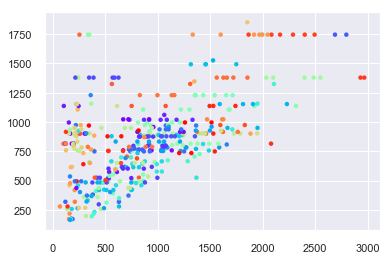

In [45]:
labels = KMeans(n_clusters=92, init='k-means++',n_init=10,random_state=1).fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');
plt.scatter(X[:, 0], X[:, 1]+np.random.random(X[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0)